In [1]:
%matplotlib inline
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- ATLAS style ---
ROOT.gROOT.LoadMacro("/home/kalelc/research/atlasstyle/AtlasStyle.C")
ROOT.gROOT.LoadMacro("/home/kalelc/research/atlasstyle/AtlasUtils.C")
ROOT.gROOT.LoadMacro("/home/kalelc/research/atlasstyle/AtlasLabels.C")
ROOT.SetAtlasStyle()

ROOT.EnableImplicitMT()

# --- Load Delphes ---
delphes_dir = "/home/kalelc/research/Delphes-3.5.0/"
status = ROOT.gSystem.Load(delphes_dir + "libDelphes.so")
if status != 0:
    raise RuntimeError("Error: Could not load libDelphes.so")
print("libDelphes.so loaded successfully!")

# Input ROOT file
fdir = delphes_dir + "displacedPhoton/displaced_half_dark_events.root"
df = ROOT.RDataFrame("Delphes", fdir)

FINAL_STATUS = 62


Applying ATLAS style settings...

libDelphes.so loaded successfully!


In [2]:
# --- Convert truth particles to pandas ---
particle_dict = df.AsNumpy([
    "Event.Number",
    "Particle.PT",
    "Particle.Eta",
    "Particle.Phi",
    "Particle.Mass",
    "Particle.PID",
    "Particle.fUniqueID",
    "Particle.M1",
    "Particle.M2",
    "Particle.D1",
    "Particle.D2",
    "Particle.P",
    "Particle.Status",
    "Particle.Charge",
    "Particle.T"
])

# Flatten event numbers (scalars, not 1-element arrays)
event_numbers = [arr[0] for arr in particle_dict["Event.Number"]]

# Add particle indices per event (needed for mother/daughter lookup)
particle_dict["Particle.Index"] = [
    np.arange(len(pt)) for pt in particle_dict["Particle.PT"]
]

# Build DataFrame
particle_df = pd.DataFrame({
    "EventNumber": event_numbers,
    "ParticleIndex": particle_dict["Particle.Index"],
    "PT": particle_dict["Particle.PT"],
    "Eta": particle_dict["Particle.Eta"],
    "Phi": particle_dict["Particle.Phi"],
    "Mass": particle_dict["Particle.Mass"],
    "PID": particle_dict["Particle.PID"],
    "UniqueID": particle_dict["Particle.fUniqueID"],  # keep for reference
    "M1": particle_dict["Particle.M1"],
    "M2": particle_dict["Particle.M2"],
    "D1": particle_dict["Particle.D1"],
    "D2": particle_dict["Particle.D2"],
    "P": particle_dict["Particle.P"],
    "Status": particle_dict["Particle.Status"],
    "Charge": particle_dict["Particle.Charge"],
    "T": particle_dict["Particle.T"],
})

# Only look at the first 500 events for now
particle_df = particle_df[particle_df["EventNumber"] < 500]

# Explode so each particle gets its own row
particle_df = particle_df.explode([
    "ParticleIndex", "PT", "Eta", "Phi", "Mass", "PID", "UniqueID",
    "M1", "M2", "D1", "D2", "P", "Status", "Charge", "T"
], ignore_index=True)

# Convert indices to integer
particle_df[["ParticleIndex", "M1", "M2", "D1", "D2"]] = particle_df[["ParticleIndex", "M1", "M2", "D1", "D2"]].astype(int)

particle_df = particle_df.sort_values(by="EventNumber").reset_index(drop=True)

particle_df

,EventNumber,ParticleIndex,PT,Eta,Phi,Mass,PID,UniqueID,M1,M2,D1,D2,P,Status,Charge,T
0,0,4,2.631126,0.541287,2.575235,0.0,21,4,0,-1,20,20,-0.0,61,0,0.0
1,0,3,2.080813,6.782842,-1.431776,0.0,2,3,0,-1,19,19,-0.0,61,0,0.0
2,0,2,3.147123,5.993112,0.045965,0.0,21,2,0,-1,18,18,-0.0,61,0,0.0
3,0,169,0.919545,-3.272425,-0.912247,0.0,21,167,142,-1,170,171,-0.0,44,0,0.0
4,0,168,1.917156,-1.411706,-2.508121,0.42207,21,166,167,-1,181,209,-0.0,71,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726317,499,1543,0.211329,2.103915,0.187459,0.13957,211,1544,1463,-1,-1,-1,-0.0,1,1,0.0
726318,499,1544,0.251334,4.338299,1.936857,0.772547,113,1545,1465,-1,1585,1586,-0.0,2,0,0.0
726319,499,1545,0.100276,4.35184,-0.241907,0.0,22,1546,1465,-1,-1,-1,-0.0,1,0,0.0
726320,499,1590,0.292068,3.004642,1.456873,0.0,22,1591,1559,-1,-1,-1,-0.0,1,0,0.0


In [ ]:
# --- Convert MissingET and GenMissingET to pandas (event-level DataFrame) ---
missingET_dict = df.AsNumpy([
    "Event.Number",
    "MissingET.MET", "MissingET.Eta", "MissingET.Phi",
    "GenMissingET.MET", "GenMissingET.Eta", "GenMissingET.Phi",
])

# Flatten event numbers and build event-level DataFrame
missingET_df = pd.DataFrame({
    "EventNumber": [arr[0] for arr in missingET_dict["Event.Number"]],
    "MET": [arr[0] for arr in missingET_dict["MissingET.MET"]],
    "MET_Eta": [arr[0] for arr in missingET_dict["MissingET.Eta"]],
    "MET_Phi": [arr[0] for arr in missingET_dict["MissingET.Phi"]],
    "GenMET": [arr[0] for arr in missingET_dict["GenMissingET.MET"]],
    "GenMET_Eta": [arr[0] for arr in missingET_dict["GenMissingET.Eta"]],
    "GenMET_Phi": [arr[0] for arr in missingET_dict["GenMissingET.Phi"]],
})

# Only keep the first 500 events
missingET_df = missingET_df[missingET_df["EventNumber"] < 500].reset_index(drop=True)

# Display first few rows
missingET_df.head()


,EventNumber,MET,MET_Eta,MET_Phi,GenMET,GenMET_Eta,GenMET_Phi
0,0,26.017002,2.314395,-1.242230,39.143513,0.179296,-1.479393
1,1,38.249065,1.742910,2.871689,23.687180,1.921988,-1.932783
2,2,50.321133,2.075560,-0.111179,95.386909,0.988994,-0.467594
3,3,55.877750,1.163212,2.176007,78.944168,2.318977,2.877817
4,4,52.695034,1.687213,-0.151504,17.324291,3.902051,-0.014991
5,5,17.066523,2.016686,-1.068859,17.414043,4.052361,1.257855
6,6,54.577896,-2.926431,-2.771443,40.491619,-1.794835,-0.889714
7,7,26.664537,-3.563340,2.994382,43.218632,-0.466603,2.967694
8,8,28.145960,-3.369802,-1.382557,35.467354,1.459448,-1.413159
9,9,41.380733,-3.311493,3.128692,67.793633,-1.357194,2.866423


In [4]:
# --- Helper: get children of a particle using D1..D2 indices ---
def get_children(df, parent_index, event_num):
    """Return daughter particles of parent_index within the same event (by ParticleIndex)."""
    parent = df[(df["ParticleIndex"] == parent_index) & (df["EventNumber"] == event_num)]
    if parent.empty:
        raise ValueError(f"Parent index {parent_index} not found in event {event_num}")
    parent = parent.iloc[0]
    d1, d2 = int(parent["D1"]), int(parent["D2"])
    if d1 < 0 or d2 < 0:
        return pd.DataFrame()  # no daughters
    return df[(df["EventNumber"] == event_num) & (df["ParticleIndex"] >= d1) & (df["ParticleIndex"] <= d2)]

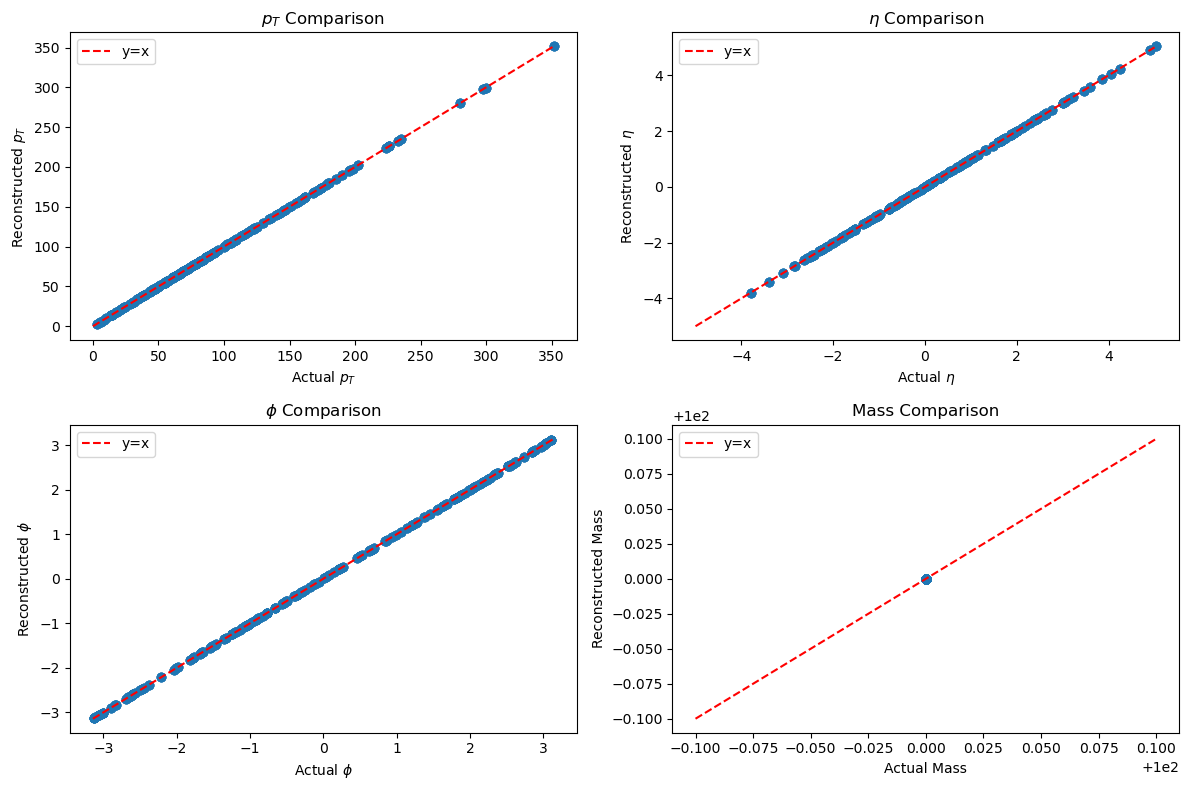

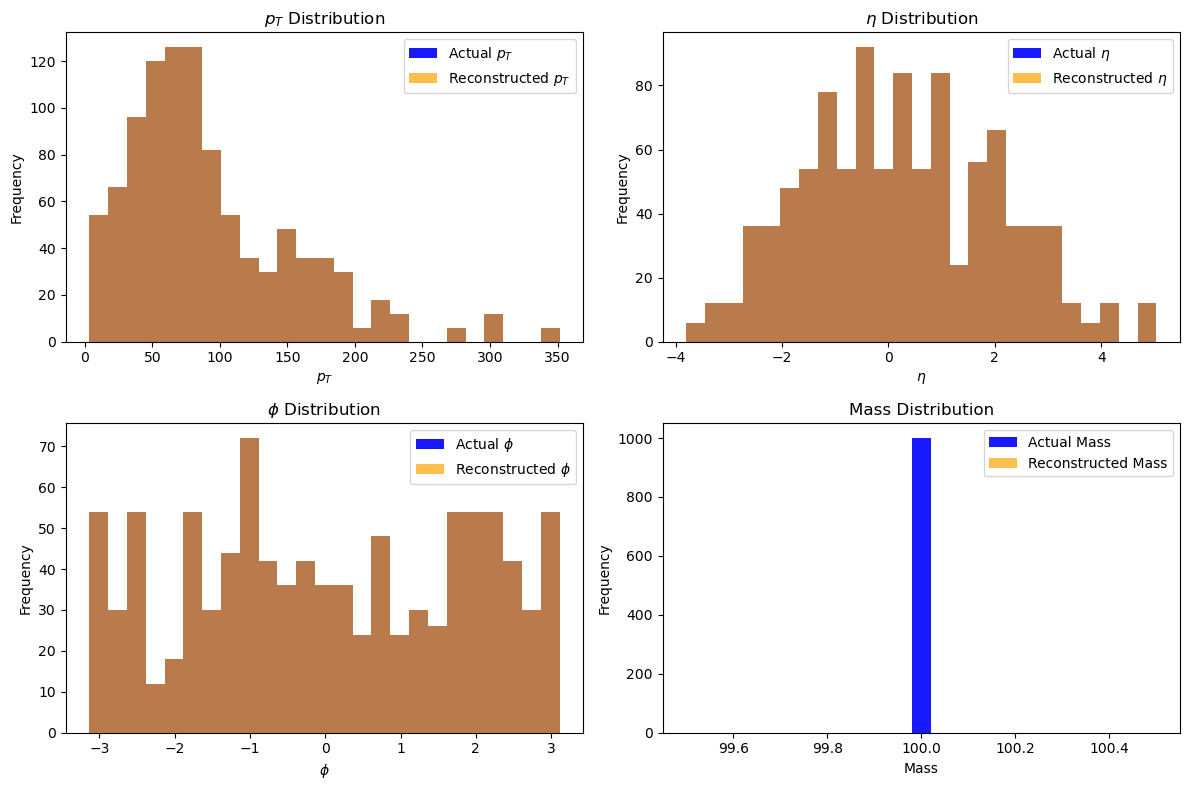

In [5]:
# --- Fill ROOT 4vector with PID54's children and reconstruct PID54 ---
reconstructed_properties = []

for ev in particle_df["EventNumber"].unique():
    ev_df = particle_df[particle_df["EventNumber"] == ev]
    pid54 = ev_df[(ev_df["PID"] == 54) & (ev_df["Status"] == FINAL_STATUS)]

    if pid54.empty:
        continue

    for _, parent in pid54.iterrows():
        children = get_children(ev_df, parent.ParticleIndex, ev)
        if children.empty:
            continue

        # Initialize ROOT 4vector for reconstructed PID54
        reconstructed_4vector = ROOT.TLorentzVector()

        for _, child in children.iterrows():
            child_4vector = ROOT.TLorentzVector()
            child_4vector.SetPtEtaPhiM(float(child["PT"]), float(child["Eta"]), float(child["Phi"]), float(child["Mass"]))
            reconstructed_4vector += child_4vector

        # Store reconstructed and actual properties for comparison
        reconstructed_properties.append({
            "EventNumber": ev,
            "ParentIndex": parent["ParticleIndex"],
            "Reconstructed_PT": reconstructed_4vector.Pt(),
            "Reconstructed_Eta": reconstructed_4vector.Eta(),
            "Reconstructed_Phi": reconstructed_4vector.Phi(),
            "Reconstructed_Mass": reconstructed_4vector.M(),
            "Actual_PT": float(parent["PT"]),
            "Actual_Eta": float(parent["Eta"]),
            "Actual_Phi": float(parent["Phi"]),
            "Actual_Mass": float(parent["Mass"]),
        })

# Convert to DataFrame for plotting
reconstructed_df = pd.DataFrame(reconstructed_properties)

# --- Plot comparisons ---
plt.figure(figsize=(12, 8))

# PT comparison
plt.subplot(2, 2, 1)
plt.scatter(reconstructed_df["Actual_PT"], reconstructed_df["Reconstructed_PT"], alpha=0.7)
plt.plot([0, reconstructed_df["Actual_PT"].max()], [0, reconstructed_df["Actual_PT"].max()], 'r--', label="y=x")
plt.xlabel("Actual $p_{T}$")
plt.ylabel("Reconstructed $p_{T}$")
plt.title("$p_{T}$ Comparison")
plt.legend()

# Eta comparison
plt.subplot(2, 2, 2)
plt.scatter(reconstructed_df["Actual_Eta"], reconstructed_df["Reconstructed_Eta"], alpha=0.7)
plt.plot([-5, 5],
         [-5, 5], 'r--', label="y=x")
plt.xlabel("Actual $\\eta$")
plt.ylabel("Reconstructed $\\eta$")
plt.title("$\\eta$ Comparison")
plt.legend()

# Phi comparison
plt.subplot(2, 2, 3)
plt.scatter(reconstructed_df["Actual_Phi"], reconstructed_df["Reconstructed_Phi"], alpha=0.7)
plt.plot([-np.pi, np.pi],
         [-np.pi, np.pi], 'r--', label="y=x")
plt.xlabel("Actual $\\phi$")
plt.ylabel("Reconstructed $\\phi$")
plt.title("$\\phi$ Comparison")
plt.legend()

# Mass comparison
plt.subplot(2, 2, 4)
plt.scatter(reconstructed_df["Actual_Mass"], reconstructed_df["Reconstructed_Mass"], alpha=0.7)
plt.plot([99.9, 100.1], [99.9, 100.1], 'r--', label="y=x")
plt.xlabel("Actual Mass")
plt.ylabel("Reconstructed Mass")
plt.title("Mass Comparison")
plt.legend()

plt.tight_layout()
plt.savefig("plots/reconstructed_vs_actual_corr.png")
plt.show()

# --- Stacked histograms for truth and reconstructed values ---
plt.figure(figsize=(12, 8))

# PT histogram
plt.subplot(2, 2, 1)
plt.hist(reconstructed_df["Actual_PT"], bins=25, alpha=0.9, label="Actual $p_{T}$", color="blue")
plt.hist(reconstructed_df["Reconstructed_PT"], bins=25, alpha=0.7, label="Reconstructed $p_{T}$", color="orange")
plt.xlabel("$p_{T}$")
plt.ylabel("Frequency")
plt.title("$p_{T}$ Distribution")
plt.legend()

# Eta histogram
plt.subplot(2, 2, 2)
plt.hist(reconstructed_df["Actual_Eta"], bins=25, alpha=0.9, label="Actual $\\eta$", color="blue")
plt.hist(reconstructed_df["Reconstructed_Eta"], bins=25, alpha=0.7, label="Reconstructed $\\eta$", color="orange")
plt.xlabel("$\\eta$")
plt.ylabel("Frequency")
plt.title("$\\eta$ Distribution")
plt.legend()

# Phi histogram
plt.subplot(2, 2, 3)
plt.hist(reconstructed_df["Actual_Phi"], bins=25, alpha=0.9, label="Actual $\\phi$", color="blue")
plt.hist(reconstructed_df["Reconstructed_Phi"], bins=25, alpha=0.7, label="Reconstructed $\\phi$", color="orange")
plt.xlabel("$\\phi$")
plt.ylabel("Frequency")
plt.title("$\\phi$ Distribution")
plt.legend()

# Mass histogram
plt.subplot(2, 2, 4)
plt.hist(reconstructed_df["Actual_Mass"], bins=25, alpha=0.9, label="Actual Mass", color="blue")
plt.hist(reconstructed_df["Reconstructed_Mass"], bins=25, alpha=0.7, label="Reconstructed Mass", color="orange")
plt.xlabel("Mass")
plt.ylabel("Frequency")
plt.title("Mass Distribution")
plt.legend()

plt.tight_layout()
plt.savefig("plots/reconstructed_vs_actual_hist.png")
plt.show()

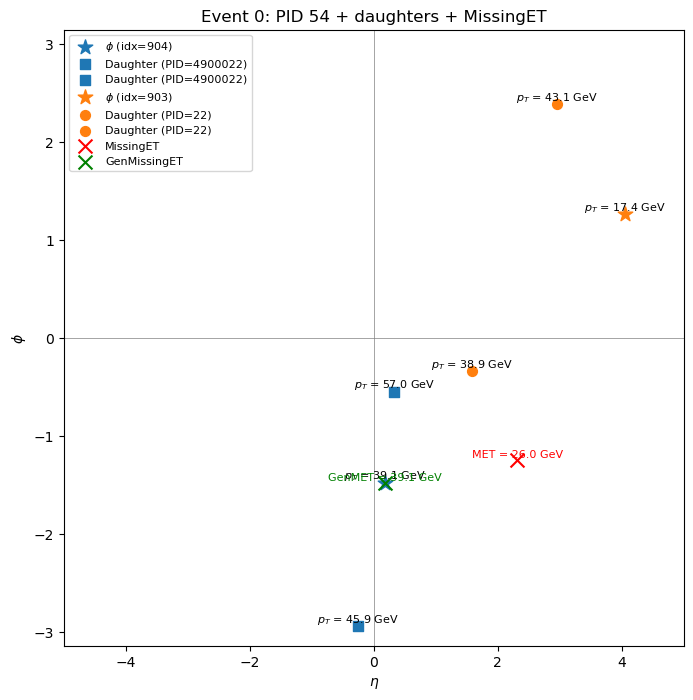

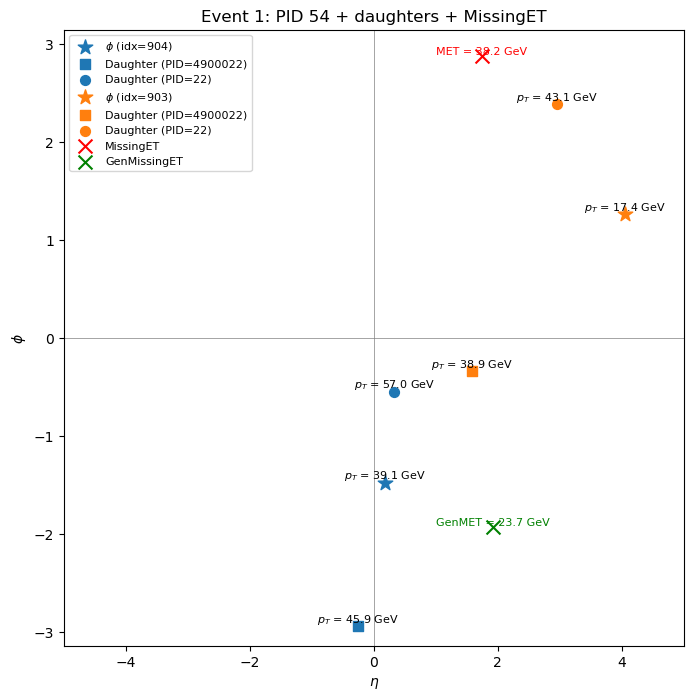

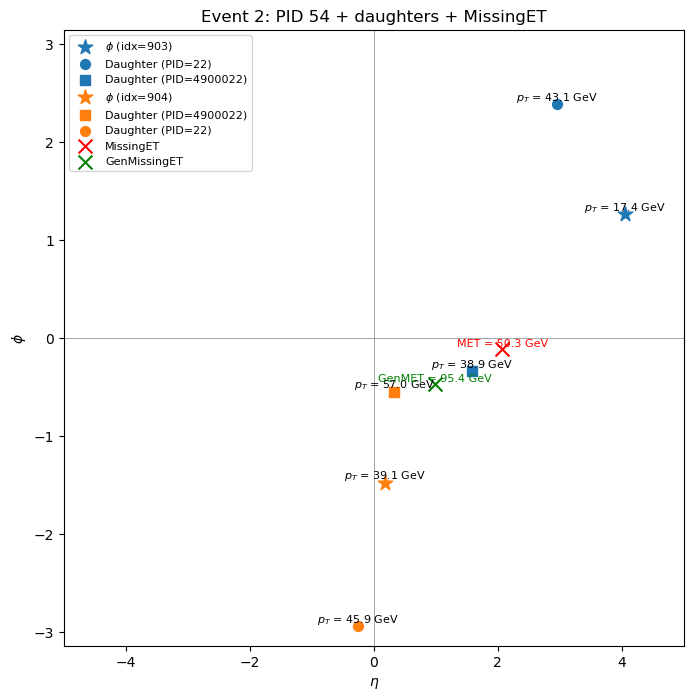

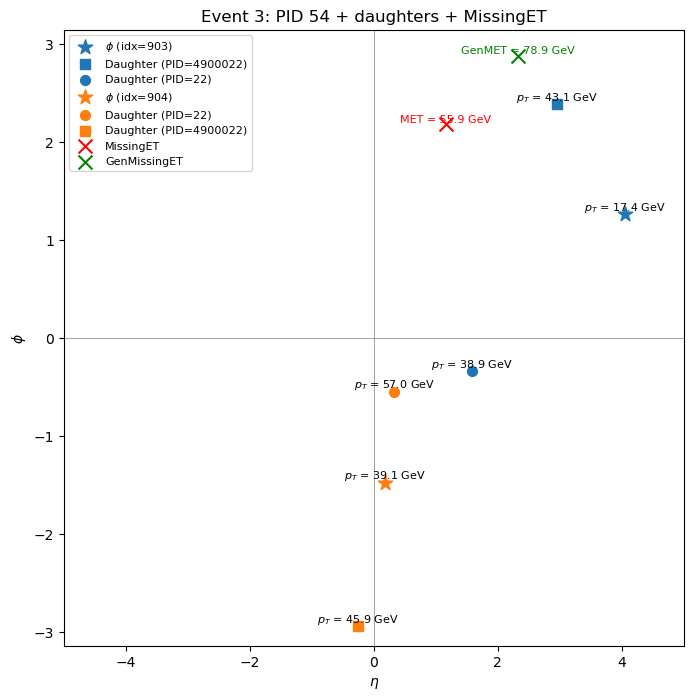

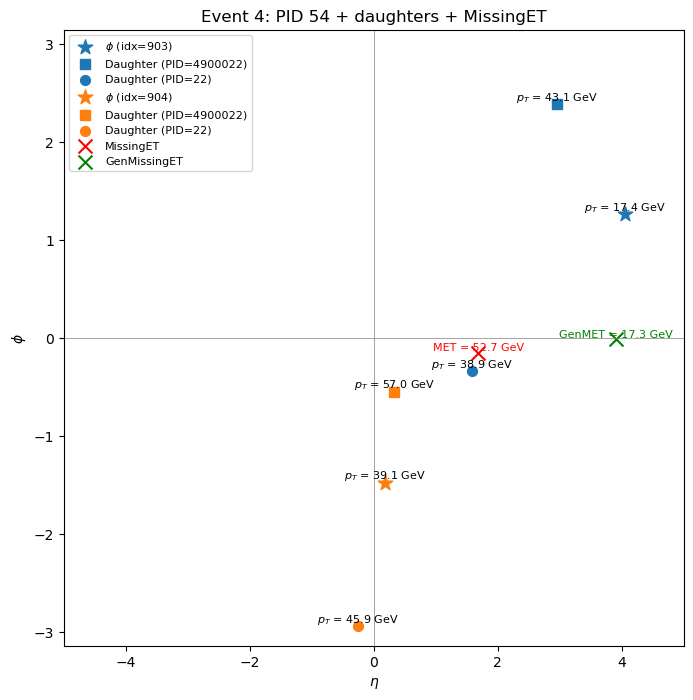

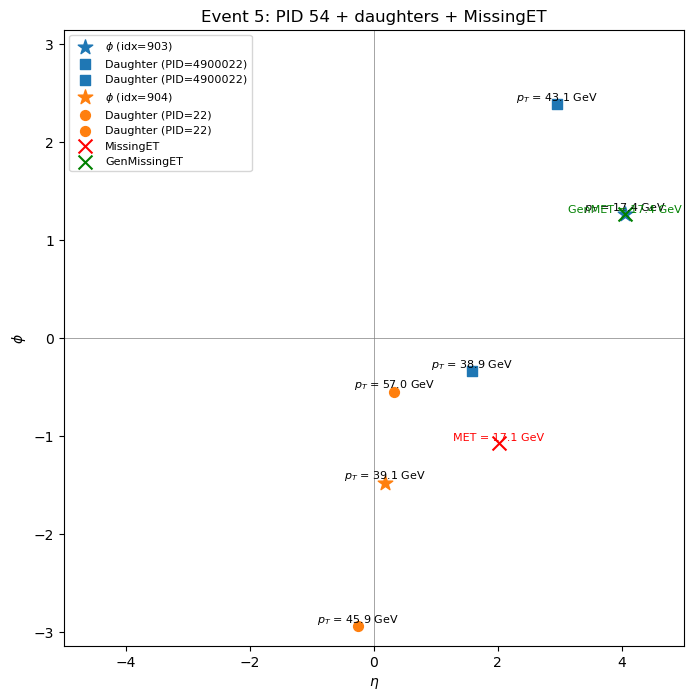

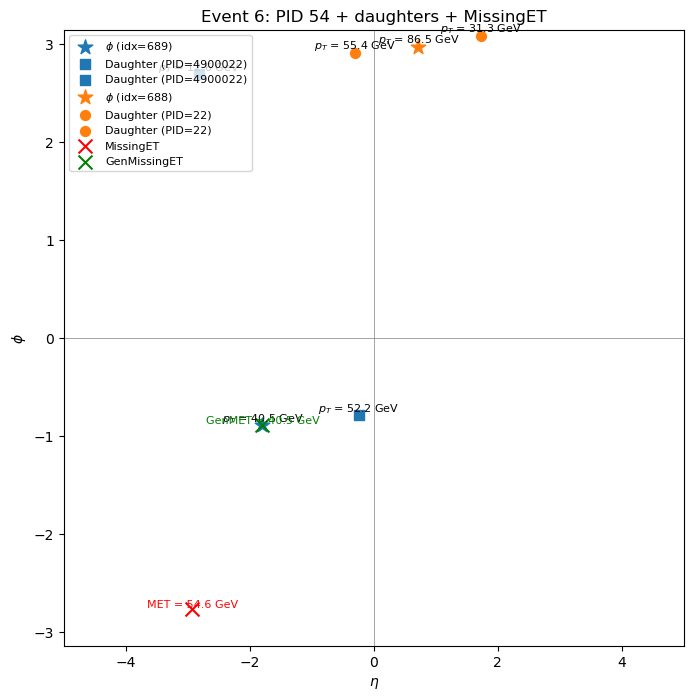

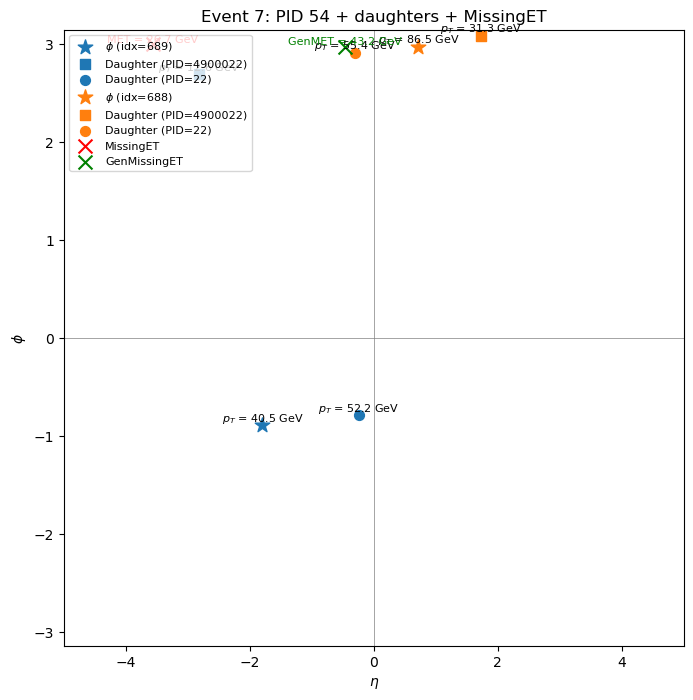

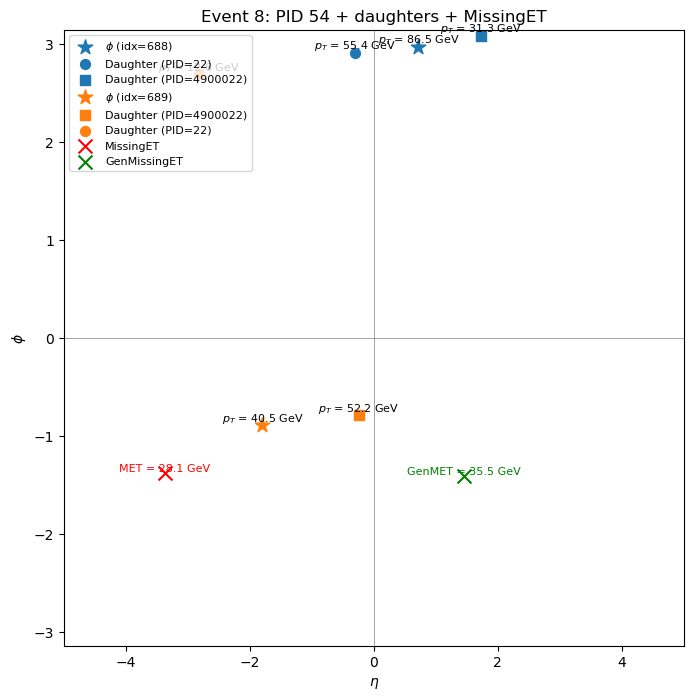

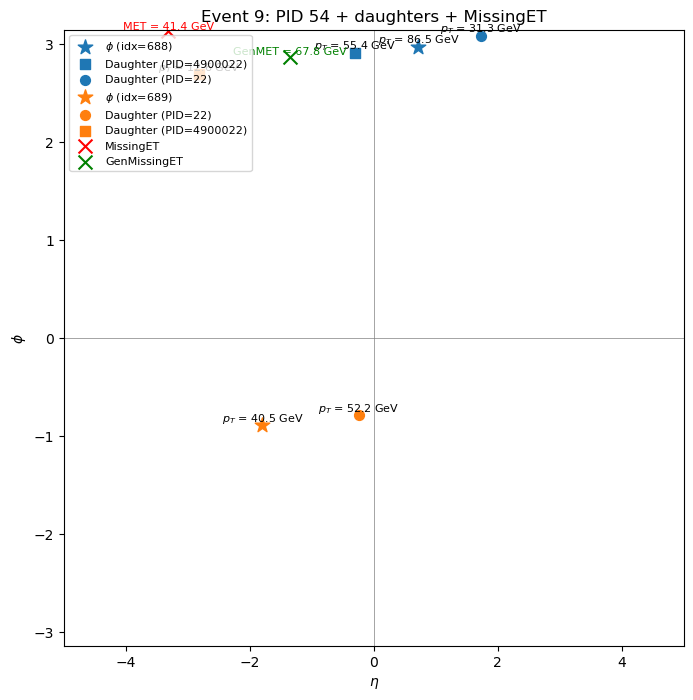

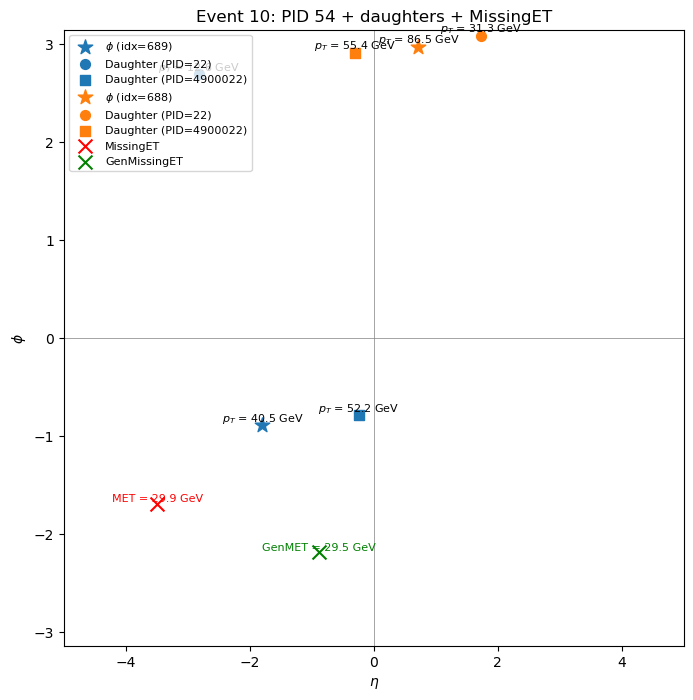

In [6]:
# --- Loop over events, find PID=54, plot daughters along with MissingET and GenMissingET ---
for ev in particle_df["EventNumber"].unique():
    ev_df = particle_df[particle_df["EventNumber"] == ev]
    pid54 = ev_df[ev_df["PID"] == 54]

    if pid54.empty:
        continue

    # Get MissingET and GenMissingET for the current event
    met_row = missingET_df[missingET_df["EventNumber"] == ev]
    if met_row.empty:
        continue
    met_row = met_row.iloc[0]

    plt.figure(figsize=(8, 8))
    plt.axhline(0, color="gray", lw=0.5)
    plt.axvline(0, color="gray", lw=0.5)

    for i, (_, parent) in enumerate(pid54.iterrows()):
        if parent["Status"] != FINAL_STATUS:
            continue
        children = get_children(ev_df, parent.ParticleIndex, ev)
        if not children.empty and not children["PID"].isin([22, 4900022]).all():
            print(f"Warning: Parent {parent.ParticleIndex} in event {ev} has non-photon/non-dark-photon daughters")
            continue

        # Generate a unique color for each parent
        i %= 2
        color = "tab:blue" if i == 0 else "tab:orange"

        # Plot parent
        plt.scatter(parent["Eta"], parent["Phi"], c=color, marker="*", s=120, label=fr"$\phi$ (idx={parent.ParticleIndex})")
        plt.text(parent["Eta"], parent["Phi"], f"$p_{{T}}$ = {parent['PT']:.1f} GeV", fontsize=8, ha='center', va='bottom', color='black')

        # Plot children
        if not children.empty:
            for _, child in children.iterrows():
                if child["PID"] == 22:  # Normal photon
                    marker = "o"
                elif child["PID"] == 4900022:  # Dark photon
                    marker = "s"
                else:
                    raise ValueError(f"Unexpected PID {child['PID']} for child of parent {parent.ParticleIndex} in event {ev}")

                plt.scatter(child["Eta"], child["Phi"], c=color, marker=marker, s=50, label=f"Daughter (PID={child['PID']})")
                plt.text(child["Eta"], child["Phi"], f"$p_{{T}}$ = {child['PT']:.1f} GeV", fontsize=8, ha='center', va='bottom', color='black')

    # Annotate MissingET and GenMissingET
    plt.scatter(met_row["MET_Eta"], met_row["MET_Phi"], c="red", marker="x", s=100, label="MissingET")
    plt.text(met_row["MET_Eta"], met_row["MET_Phi"], f"MET = {met_row['MET']:.1f} GeV", fontsize=8, ha='center', va='bottom', color='red')

    plt.scatter(met_row["GenMET_Eta"], met_row["GenMET_Phi"], c="green", marker="x", s=100, label="GenMissingET")
    plt.text(met_row["GenMET_Eta"], met_row["GenMET_Phi"], f"GenMET = {met_row['GenMET']:.1f} GeV", fontsize=8, ha='center', va='bottom', color='green')

    plt.xlabel(r"$\eta$")
    plt.ylabel(r"$\phi$")
    plt.xlim(-5, 5)
    plt.ylim(-np.pi, np.pi)
    plt.title(f"Event {ev}: PID 54 + daughters + MissingET")
    plt.legend(loc='upper left', fontsize=8)
        
    print_display = 0
    
    if ev == print_display:
        plt.savefig(f"plots/displaced_half_dark_event_{ev}_display.png", bbox_inches='tight')
        
    plt.show()
    if ev >= 10:  # limit number of events displayed
        break
